In [1]:
import sys
import os

# Добавляем корень проекта в sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)


In [2]:
!git clone https://github.com/denis201520182022/colorization-project.git

Cloning into 'colorization-project'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 157 (delta 11), reused 11 (delta 1), pack-reused 125 (from 1)
Receiving objects: 100% (157/157), 53.04 MiB | 14.06 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [3]:
%cd colorization-project
from utils.color_utils import lab_to_rgb_tensor
from datasets.dataset_lab_V1 import CIFAR10_Lab
from datasets.dataset_rgb import ColorizationDataset
from models.lab_model.model_lab_V1 import ColorizationCNN
from models.lab_model.model_lab_V2 import SuperColorizationNet
from models.rgb_model.model_rgb import ColorizationNet


/content/colorization-project


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import CIFAR10
from skimage import color
from skimage.color import lab2rgb

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Загружаем модели
model1 = ColorizationNet().to(device)
model1.load_state_dict(torch.load('/content/colorization-project/saved_models/colorization_model_rgb.pth'))

model1.eval()

model2 = SuperColorizationNet().to(device)
model2.load_state_dict(torch.load("/content/colorization-project/saved_models/colorization_weights_lab_V2.pth"))
model2.eval()

model3 = ColorizationCNN().to(device)
model3.load_state_dict(torch.load("/content/colorization-project/saved_models/colorization_weights_lab_V1.pth"))
model3.eval()


ColorizationCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
  )
)

In [8]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision.transforms.functional import rgb_to_grayscale
from torchvision.datasets import CIFAR10

In [15]:


transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])


test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
test_dataset_rgb = ColorizationDataset(test_dataset)
test_loader_rgb = DataLoader(test_dataset_rgb, batch_size=32, shuffle=False)



In [16]:


test_dataset_lab_v2 = CIFAR10_Lab(train=False)
test_loader_lab_v2 = DataLoader(test_dataset_lab_v2, batch_size=32, shuffle=False)

test_dataset_lab_v1 = CIFAR10_Lab(train=False)
test_loader_lab_v1 = DataLoader(test_dataset_lab_v1, batch_size=32, shuffle=False)

In [17]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch.nn.functional as F


In [18]:
def compute_metrics(output, target):
    output = output.detach().cpu().numpy()
    target = target.detach().cpu().numpy()

    mse = np.mean((output - target) ** 2)
    psnr_val = psnr(target, output, data_range=1.0)
    ssim_val = ssim(np.transpose(target, (1, 2, 0)),
                    np.transpose(output, (1, 2, 0)),
                    data_range=1.0, channel_axis=2)
    return mse, psnr_val, ssim_val


In [19]:
def test_model_rgb(model, dataloader):
    model.eval()
    total_mse, total_psnr, total_ssim, count = 0, 0, 0, 0

    with torch.no_grad():
        for gray, color in tqdm(dataloader):  # batch: (grayscale, target_color)
            gray = gray.to(device)
            color = color.to(device)

            output = model(gray)
            for i in range(output.size(0)):  # пробегаемся по batch'у
                pred_img = output[i]
                true_img = color[i]

                mse, psnr_val, ssim_val = compute_metrics(pred_img, true_img)
                total_mse += mse
                total_psnr += psnr_val
                total_ssim += ssim_val
                count += 1

    return total_mse / count, total_psnr / count, total_ssim / count


In [20]:
mse1, psnr1, ssim1 = test_model_rgb(model1, test_loader_rgb)
print("Model 1 (RGB) — MSE:", mse1, "PSNR:", psnr1, "SSIM:", ssim1)


100%|██████████| 313/313 [00:20<00:00, 15.01it/s]

Model 1 (RGB) — MSE: 0.005429746 PSNR: 24.64668931870637 SSIM: 0.9129948


In [46]:


# # Функция для вычисления Pixel Accuracy
# def pixel_accuracy(predicted, ground_truth, threshold=0.1):
#     """
#     Вычисляет точность пикселей: насколько предсказания близки к истинным.
#     """
#     diff = np.abs(predicted - ground_truth)
#     correct = np.sum(diff < threshold)
#     total = np.prod(ground_truth.shape)  # Общее количество пикселей
#     return correct / total

# Функция для вычисления MSE
def mean_squared_error(predicted, ground_truth):
    return np.mean((predicted - ground_truth) ** 2)

def test_model_with_visualization(model, test_loader, device):
    model.eval()

    pixel_acc_list = []
    ssim_list = []
    psnr_list = []
    mse_list = []

    with torch.no_grad():
        for L, ab in test_loader:
            L, ab = L.to(device), ab.to(device)

            # Предсказание ab-каналов
            output_ab = model(L)

            # Преобразуем тензоры в numpy массивы для метрик
            output_ab = output_ab.squeeze(0).cpu().numpy() * 128  # Преобразуем в диапазон от -128 до 128
            ab_np = ab.squeeze(0).cpu().numpy() * 128  # Истинные значения для сравнения

            for i in range(output_ab.shape[0]):
                single_output_ab = output_ab[0]  # Берём первое изображение из батча

                single_ab_np = ab_np[0]

                single_L = L[0]

                # Переводим аб-каналы в (32, 32, 2) для оценки
                ab_pred = single_output_ab.transpose(1, 2, 0)
                ab_true = single_ab_np.transpose(1, 2, 0)
                L_np = single_L.squeeze(0).cpu().numpy() * 100

                # Собираем обратно LAB картинку для предсказанного изображения
                lab_img_pred = np.zeros((32, 32, 3), dtype=np.float32)
                lab_img_pred[:, :, 0] = L_np
                lab_img_pred[:, :, 1:] = ab_pred
                rgb_img_pred = lab2rgb(lab_img_pred)

                # Собираем обратно LAB картинку для истинного изображения
                lab_img_true = np.zeros((32, 32, 3), dtype=np.float32)
                lab_img_true[:, :, 0] = L_np
                lab_img_true[:, :, 1:] = ab_true
                rgb_img_true = lab2rgb(lab_img_true)



                # Оценка SSIM
                ssim_value = ssim(lab_img_pred, lab_img_true, multichannel=True, win_size=3, data_range=128)
                ssim_list.append(ssim_value)
                # Оценка PSNR
                psnr_value = psnr(ab_true, ab_pred, data_range=128)
                psnr_list.append(psnr_value)
                # Оценка MSE
                mse_value = mean_squared_error(ab_pred, ab_true)
                mse_list.append(mse_value)

    # Среднее значение метрик
    # avg_pixel_acc = np.mean(pixel_acc_list)
    avg_ssim = np.mean(ssim_list)
    avg_psnr = np.mean(psnr_list)
    avg_mse = np.mean(mse_list)

    return avg_ssim, avg_psnr, avg_mse






In [47]:
ssim_val, psnr_val, mse_val = test_model_with_visualization(model2, test_loader_lab_v2, device)
print("MSE:", mse_val, "PSNR:", psnr_val, "SSIM:", ssim_val)



MSE: 125.738525 PSNR: 23.02806131416367 SSIM: 0.8895869227831831


In [48]:
ssim_val, psnr_val, mse_val = test_model_with_visualization(model3, test_loader_lab_v1, device)
print("MSE:", mse_val, "PSNR:", psnr_val, "SSIM:", ssim_val)



MSE: 133.50404 PSNR: 22.783148680225228 SSIM: 0.8829792035528348


In [49]:
import pandas as pd
from tabulate import tabulate

# Данные
data = {
    "Модель": ["Model 1 (RGB)", "Model 2 (Lab_V2)", "Model 3 (Lab_V1)"],
    "MSE": [0.0054, 125.74, 133.50],
    "PSNR": [24.65, 23.03, 22.78],
    "SSIM": [0.913, 0.890, 0.883]
}

df = pd.DataFrame(data)

# Красивый вывод
print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))


+------------------+----------+--------+--------+
| Модель           |      MSE |   PSNR |   SSIM |
+==================+==========+========+========+
| Model 1 (RGB)    |   0.0054 |  24.65 |  0.913 |
+------------------+----------+--------+--------+
| Model 2 (Lab_V2) | 125.74   |  23.03 |  0.89  |
+------------------+----------+--------+--------+
| Model 3 (Lab_V1) | 133.5    |  22.78 |  0.883 |
+------------------+----------+--------+--------+


In [95]:
import random

l = len(test_loader_lab_v2.dataset)
random_indexes = random.sample(range(l), 3)


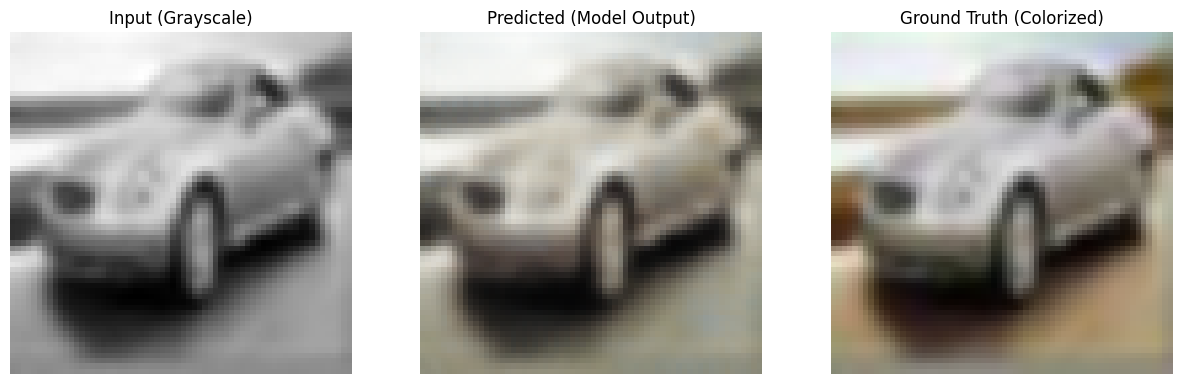

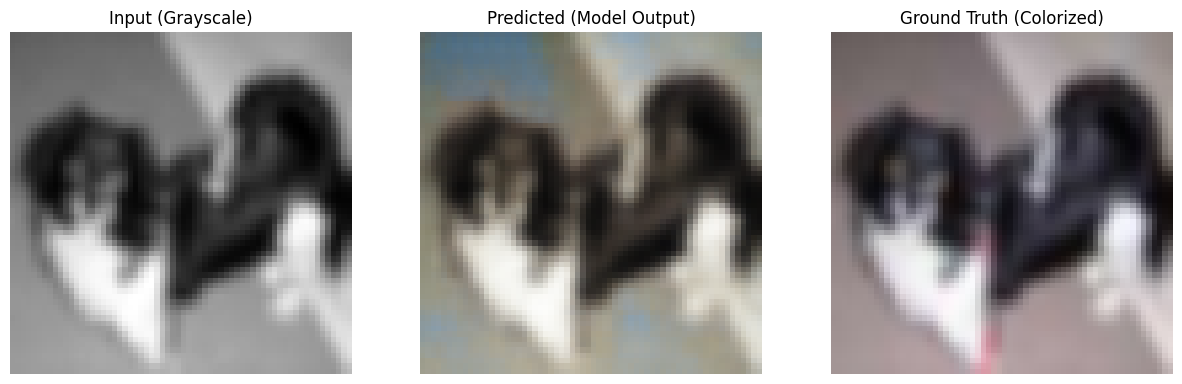

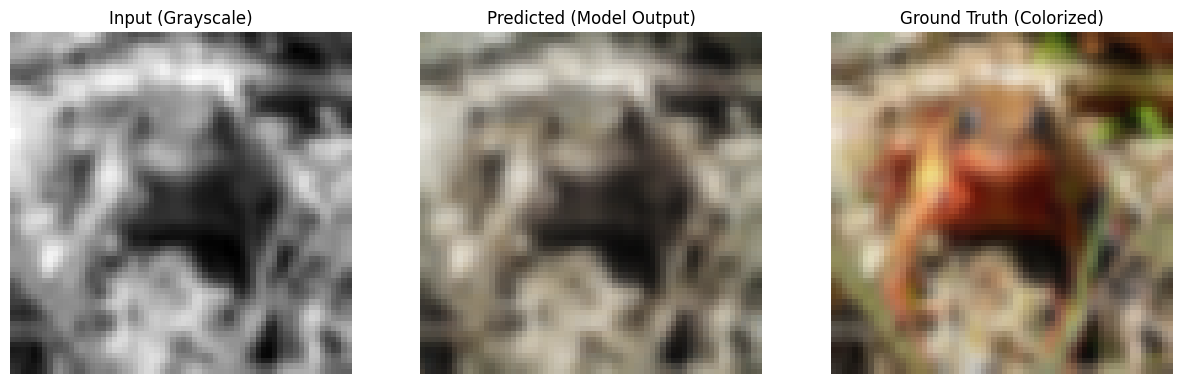

In [96]:

for idx in random_indexes:
  a, b = test_dataset_rgb[idx]


  with torch.no_grad():
    a = a.to(device).float()
    b = b.to(device).float()

    out_b = model1(a)
    a_np = a.squeeze(0).cpu().numpy()  # ЧБ изображение
    b_np = b.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Реальное цветное изображение
    out_b_np = out_b.squeeze(0).cpu().numpy().transpose(1, 2, 0)

    # Визуализируем
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(a_np, cmap='gray')  # ЧБ изображение
    axes[0].set_title("Input (Grayscale)")
    axes[0].axis('off')

    axes[1].imshow(out_b_np)  # Предсказанное цветное изображение
    axes[1].set_title("Predicted (Model Output)")
    axes[1].axis('off')

    axes[2].imshow(b_np)  # Реальное цветное изображение
    axes[2].set_title("Ground Truth (Colorized)")
    axes[2].axis('off')

    plt.show()


torch.Size([2, 32, 32])


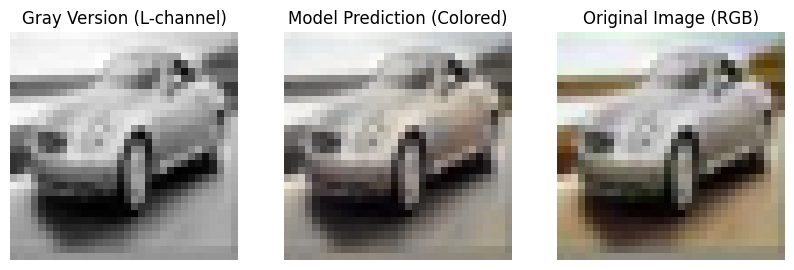

torch.Size([2, 32, 32])


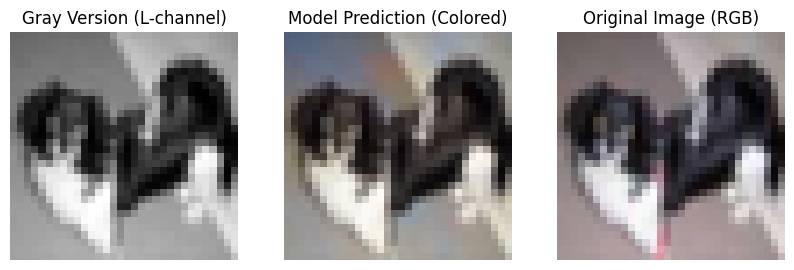

torch.Size([2, 32, 32])


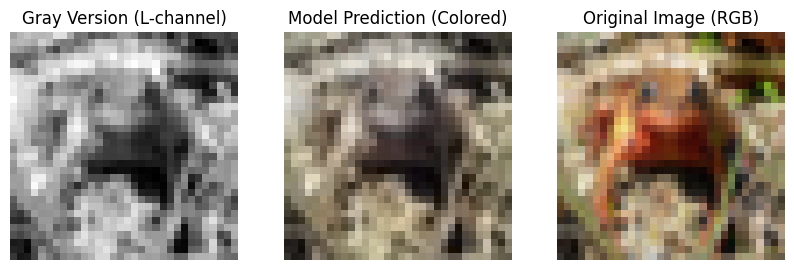

In [97]:

for idx in random_indexes:
  L, ab = test_dataset_lab_v2[idx]
  # print(L.shape, ab.shape)
  with torch.no_grad():
    L, ab = L.to(device), ab.to(device)
    output = model3(L)
    print(output.shape)

    output = output.squeeze(0).cpu().numpy() * 128  # Преобразуем в диапазон от -128 до 128
    ab_np = ab.squeeze(0).cpu().numpy() * 128  # Истинные значения для сравнения


                # Переводим аб-каналы в (32, 32, 2) для оценки
    ab_pred = output.transpose(1, 2, 0)
    ab_true = ab_np.transpose(1, 2, 0)
    L_np = L.squeeze(0).cpu().numpy() * 100

              # Собираем обратно LAB картинку для предсказанного изображения
    lab_img_pred = np.zeros((32, 32, 3), dtype=np.float32)
    lab_img_pred[:, :, 0] = L_np
    lab_img_pred[:, :, 1:] = ab_pred
    rgb_img_pred = lab2rgb(lab_img_pred)

                # Собираем обратно LAB картинку для истинного изображения
    lab_img_true = np.zeros((32, 32, 3), dtype=np.float32)
    lab_img_true[:, :, 0] = L_np
    lab_img_true[:, :, 1:] = ab_true
    rgb_img_true = lab2rgb(lab_img_true)

     # Визуализируем три изображения
    plt.figure(figsize=(10, 5))



                # Серая версия (L-канал)
    plt.subplot(1, 3, 1)
    plt.imshow(L_np, cmap='gray')
    plt.title("Gray Version (L-channel)")
    plt.axis('off')

                # Раскрашенная версия (предсказание модели)
    plt.subplot(1, 3, 2)
    plt.imshow(rgb_img_pred)
    plt.title("Model Prediction (Colored)")
    plt.axis('off')

    # Оригинальное изображение (в цвете)
    plt.subplot(1, 3, 3)
    plt.imshow(lab2rgb(np.concatenate([L_np[..., np.newaxis], ab_true], axis=-1)))
    plt.title("Original Image (RGB)")
    plt.axis('off')

    plt.show()


torch.Size([1, 32, 32]) torch.Size([2, 32, 32])
torch.Size([1, 2, 32, 32])


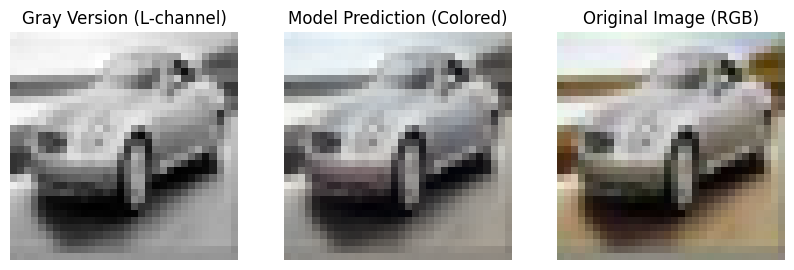

torch.Size([1, 32, 32]) torch.Size([2, 32, 32])
torch.Size([1, 2, 32, 32])


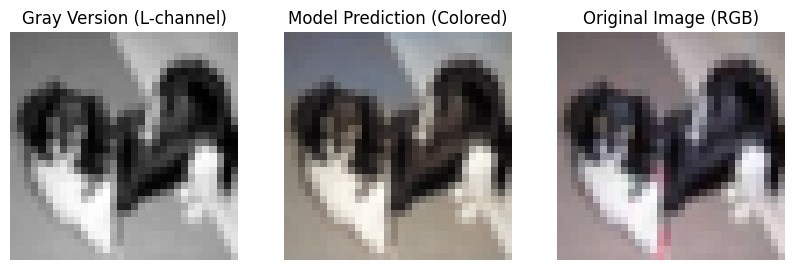

torch.Size([1, 32, 32]) torch.Size([2, 32, 32])
torch.Size([1, 2, 32, 32])


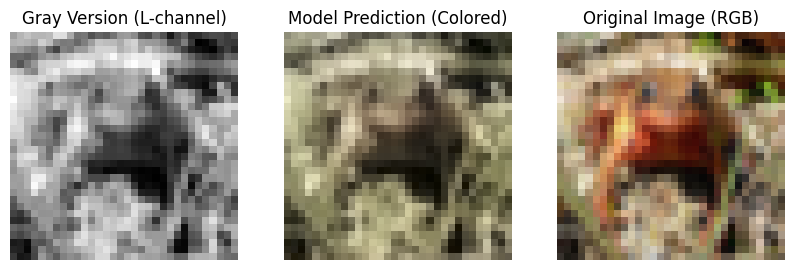

In [98]:

for idf in random_indexes:
  L, ab = test_dataset_lab_v1[idf]
  print(L.shape, ab.shape)
  with torch.no_grad():
    L = L.to(device).unsqueeze(0)
    ab = ab.to(device)
    output = model2(L)
    print(output.shape)

    output = output.squeeze(0).cpu().numpy() * 128  # Преобразуем в диапазон от -128 до 128
    ab_np = ab.squeeze(0).cpu().numpy() * 128  # Истинные значения для сравнения


                # Переводим аб-каналы в (32, 32, 2) для оценки
    ab_pred = output.transpose(1, 2, 0)
    ab_true = ab_np.transpose(1, 2, 0)
    L_np = L.squeeze(0).cpu().numpy() * 100

              # Собираем обратно LAB картинку для предсказанного изображения
    lab_img_pred = np.zeros((32, 32, 3), dtype=np.float32)
    lab_img_pred[:, :, 0] = L_np
    lab_img_pred[:, :, 1:] = ab_pred
    rgb_img_pred = lab2rgb(lab_img_pred)

                # Собираем обратно LAB картинку для истинного изображения
    lab_img_true = np.zeros((32, 32, 3), dtype=np.float32)
    lab_img_true[:, :, 0] = L_np
    lab_img_true[:, :, 1:] = ab_true
    rgb_img_true = lab2rgb(lab_img_true)
    L_np = L_np.squeeze(0)
     # Визуализируем три изображения
    plt.figure(figsize=(10, 5))



                # Серая версия (L-канал)
    plt.subplot(1, 3, 1)
    plt.imshow(L_np, cmap='gray')
    plt.title("Gray Version (L-channel)")
    plt.axis('off')

                # Раскрашенная версия (предсказание модели)
    plt.subplot(1, 3, 2)
    plt.imshow(rgb_img_pred)
    plt.title("Model Prediction (Colored)")
    plt.axis('off')

    # Оригинальное изображение (в цвете)
    plt.subplot(1, 3, 3)
    plt.imshow(lab2rgb(np.concatenate([L_np[..., np.newaxis], ab_true], axis=-1)))
    plt.title("Original Image (RGB)")
    plt.axis('off')

    plt.show()


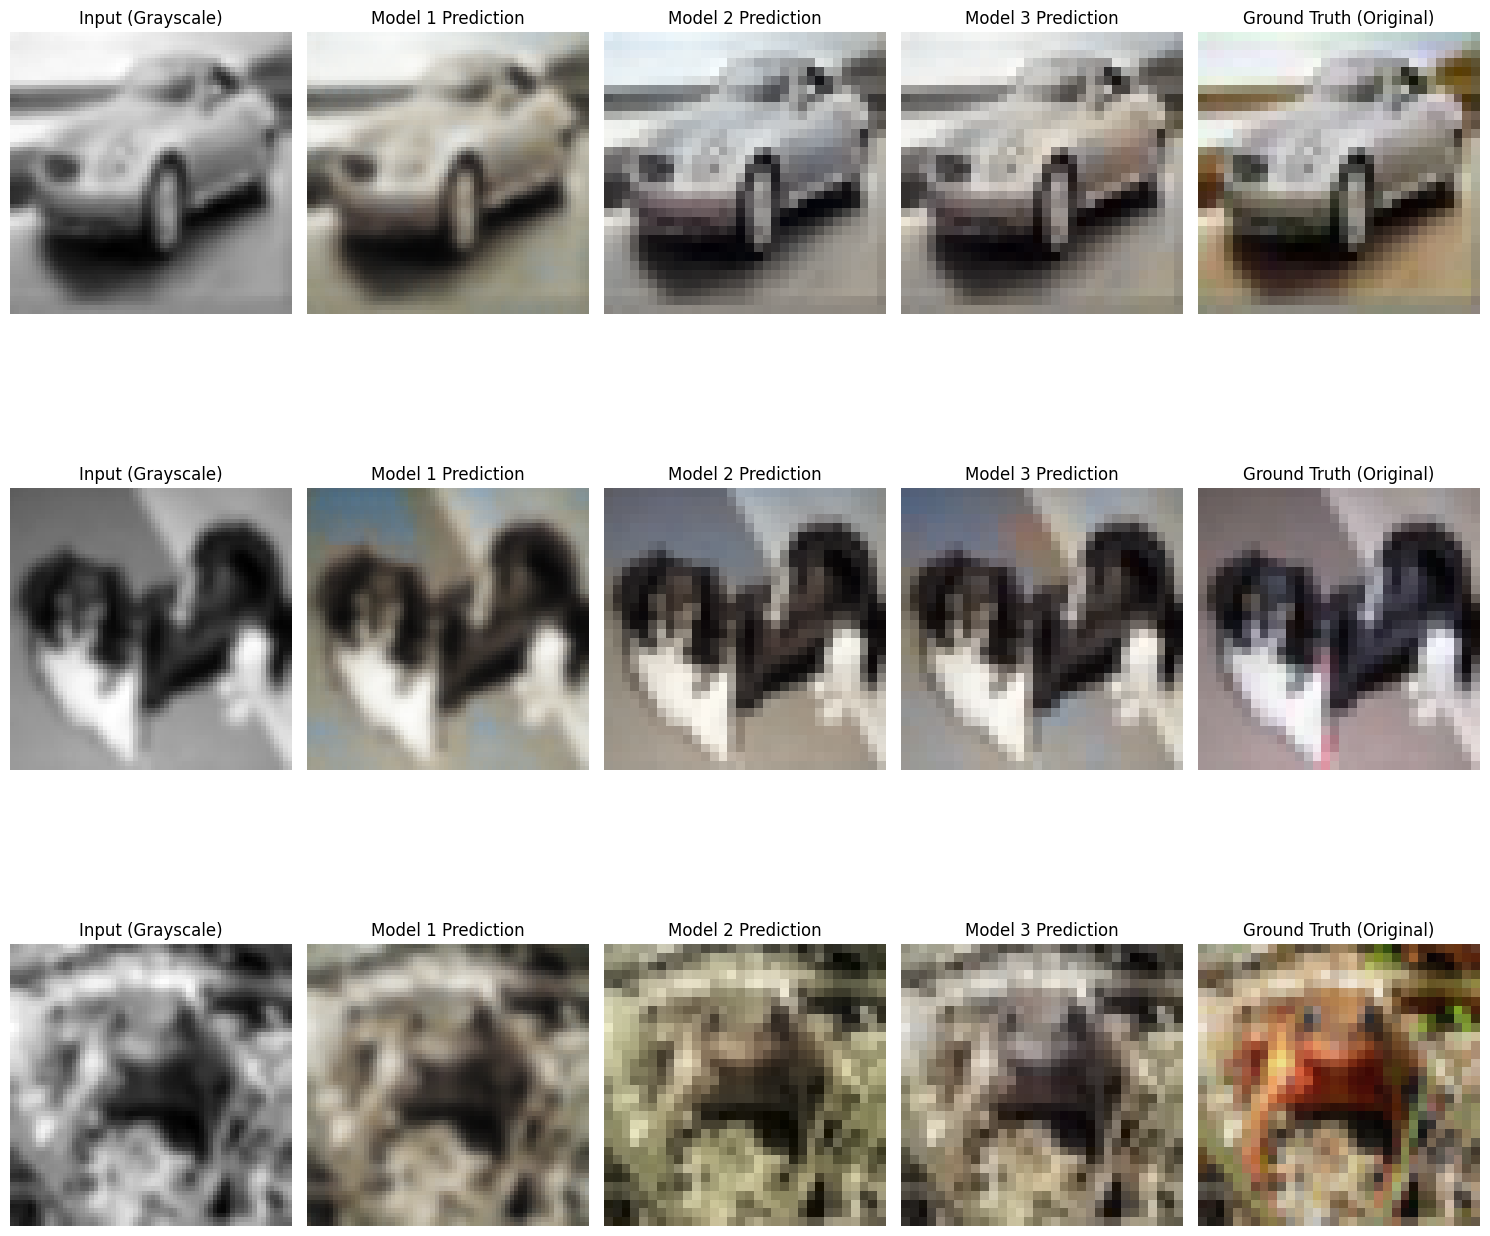

In [99]:
import matplotlib.pyplot as plt
import numpy as np



# Подготовим фигуру для всех изображений
fig, axes = plt.subplots(len(random_indexes), 5, figsize=(15, 5 * len(random_indexes)))

# Итерация по случайным индексам для отображения
for i, idx in enumerate(random_indexes):
    # ЧБ изображение и реальное для первой модели
    a, b = test_dataset_rgb[idx]

    with torch.no_grad():
        a = a.to(device).float()
        b = b.to(device).float()

        # Предсказание для модели 1
        out_b = model1(a)
        a_np = a.squeeze(0).cpu().numpy()  # ЧБ изображение
        b_np = b.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Реальное цветное изображение
        out_b_np = out_b.squeeze(0).cpu().numpy().transpose(1, 2, 0)

        # Перевод для модели 2
        L, ab = test_dataset_lab_v2[idx]
        L, ab = L.to(device), ab.to(device)
        output = model3(L)
        output = output.squeeze(0).cpu().numpy() * 128
        ab_np = ab.squeeze(0).cpu().numpy() * 128
        ab_pred = output.transpose(1, 2, 0)
        ab_true = ab_np.transpose(1, 2, 0)
        L_np = L.squeeze(0).cpu().numpy() * 100

        lab_img_pred = np.zeros((32, 32, 3), dtype=np.float32)
        lab_img_pred[:, :, 0] = L_np
        lab_img_pred[:, :, 1:] = ab_pred
        rgb_img_pred = lab2rgb(lab_img_pred)

        lab_img_true = np.zeros((32, 32, 3), dtype=np.float32)
        lab_img_true[:, :, 0] = L_np
        lab_img_true[:, :, 1:] = ab_true
        rgb_img_true = lab2rgb(lab_img_true)

        # Перевод для модели 3
        L, ab = test_dataset_lab_v1[idx]
        L = L.to(device).unsqueeze(0)
        ab = ab.to(device)
        output = model2(L)
        output = output.squeeze(0).cpu().numpy() * 128
        ab_np = ab.squeeze(0).cpu().numpy() * 128
        ab_pred = output.transpose(1, 2, 0)
        ab_true = ab_np.transpose(1, 2, 0)
        L_np = L.squeeze(0).cpu().numpy() * 100

        lab_img_pred2 = np.zeros((32, 32, 3), dtype=np.float32)
        lab_img_pred2[:, :, 0] = L_np
        lab_img_pred2[:, :, 1:] = ab_pred
        rgb_img_pred2 = lab2rgb(lab_img_pred2)

        lab_img_true2 = np.zeros((32, 32, 3), dtype=np.float32)
        lab_img_true2[:, :, 0] = L_np
        lab_img_true2[:, :, 1:] = ab_true
        rgb_img_true2 = lab2rgb(lab_img_true2)

        # Отображение
        axes[i, 0].imshow(a_np, cmap='gray')  # ЧБ изображение
        axes[i, 0].set_title("Input (Grayscale)")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(out_b_np)  # Предсказанное цветное изображение моделью 1
        axes[i, 1].set_title("Model 1 Prediction")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(rgb_img_pred2)  # Предсказанное цветное изображение моделью 2
        axes[i, 2].set_title("Model 2 Prediction")
        axes[i, 2].axis('off')

        axes[i, 3].imshow(rgb_img_pred)  # Предсказанное цветное изображение моделью 3
        axes[i, 3].set_title("Model 3 Prediction")
        axes[i, 3].axis('off')

        axes[i, 4].imshow(rgb_img_true)  # Оригинальное цветное изображение
        axes[i, 4].set_title("Ground Truth (Original)")
        axes[i, 4].axis('off')

plt.tight_layout()
plt.show()
